In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [10]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

ls: cannot access 'data_dir': No such file or directory


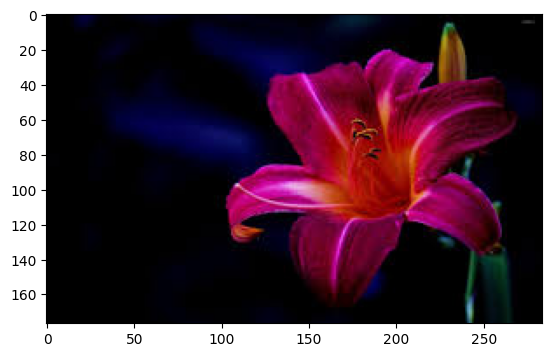

In [11]:
data_dir = "/content/drive/MyDrive/dataset"

!ls data_dir

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open("/content/drive/MyDrive/dataset/Lily/Lily (10).jpeg", 'r')
imshow(np.asarray(pil_im))

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import glob

datagen = ImageDataGenerator(
  horizontal_flip=False,
	vertical_flip=False,
	rotation_range=25,
	zoom_range=0.20,
	shear_range=0.20,
	fill_mode="nearest")

for i in range(5):
  clases=("Daisy","Lavender","Lily","Rose","Sunflower")
  for name in glob.glob(data_dir+clases[i]+"/*.jpeg"):
    img = load_img(name)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    j = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=data_dir+clases[i],
                              save_prefix="image", save_format='jpeg'):
      j += 1
      if j >= 2:
        break
print("Aumento de datos finalizado")

Aumento de datos finalizado


In [13]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 5867 files belonging to 5 classes.
Using 4694 files for training.
Found 5867 files belonging to 5 classes.
Using 1173 files for validation.


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5), offset=-1, input_shape=(150, 150, 3)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [15]:
epochs = 150

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/150
147/147 [==============================] - 27s 150ms/step - loss: 1.2550 - accuracy: 0.5639 - val_loss: 1.3360 - val_accuracy: 0.5840
Epoch 2/150
147/147 [==============================] - 19s 127ms/step - loss: 0.8787 - accuracy: 0.6779 - val_loss: 1.0923 - val_accuracy: 0.6667
Epoch 3/150
147/147 [==============================] - 19s 127ms/step - loss: 0.7816 - accuracy: 0.7113 - val_loss: 1.0725 - val_accuracy: 0.6147
Epoch 4/150
147/147 [==============================] - 19s 125ms/step - loss: 0.6723 - accuracy: 0.7456 - val_loss: 0.9532 - val_accuracy: 0.7118
Epoch 5/150
147/147 [==============================] - 19s 124ms/step - loss: 0.5743 - accuracy: 0.7846 - val_loss: 0.9135 - val_accuracy: 0.6760
Epoch 6/150
147/147 [==============================] - 19s 124ms/step - loss: 0.4919 - accuracy: 0.8176 - val_loss: 0.7815 - val_accuracy: 0.7485
Epoch 7/150
147/147 [==============================] - 19s 124ms/step - loss: 0.4198 - accuracy: 0.8462 - val_loss: 0.7476 -

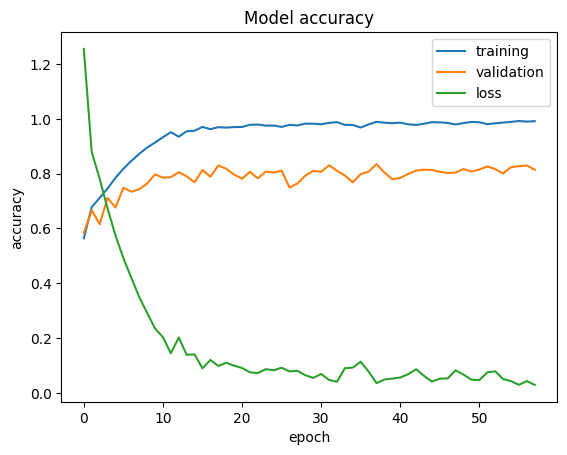

In [16]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()